## Beginning

In [1]:
import pandas as pd
import numpy as np
import regex as re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from statistics import multimode
from apyori import apriori
import utils

classifiers = ["FTD", "GINCO", "CORE", "GINCO-X-GENRE", "FTD-X-GENRE", "CORE-X-GENRE", "X-GENRE"]

# Open the file

# Show all columns
pd.set_option('display.max_columns', None)

corpus_name = "MaCoCu-mk"

corpus = pd.read_csv("MaCoCu-mk_with_predictions.csv",index_col=0, sep="\t")

# Define the extended corpus and domain-level corpus if you already created them
#corpus = pd.read_csv(f"MaCoCu-mk_with_predictions.csv", sep="\t", index_col = 0)
extended_corpus = pd.read_csv(f"MaCoCu-mk_with_predictions-domain-info-added.csv", sep="\t", index_col = 0)
genre_distribution = pd.read_csv(f"MaCoCu-mk-domain-level.csv", sep="\t", index_col = 0)

## General analysis

### Label confidence per classifier

In [4]:
# Print the label confidence for each classifier
utils.label_confidence(corpus, classifiers)

| classifier    |   min |   median |   max |
|:--------------|------:|---------:|------:|
| X-GENRE       |  0.32 |     1    |  1    |
| GINCO-X-GENRE |  0.28 |     0.98 |  0.99 |
| GINCO         |  0.24 |     0.95 |  0.98 |
| CORE          |  0.24 |     0.91 |  0.99 |
| FTD-X-GENRE   |  0.22 |     0.83 |  0.97 |
| FTD           |  0.16 |     0.77 |  0.96 |
| CORE-X-GENRE  |  0.15 |     0.64 |  0.95 |


### Most frequent values per classifier

In [5]:
utils.most_frequent_values(corpus, classifiers)

| classifier    | most frequent label                             |
|:--------------|:------------------------------------------------|
| FTD           | ('A12 (promotion)', 0.42)                       |
| GINCO         | ('News/Reporting', 0.31)                        |
| CORE          | ('Informational Description/Explanation', 0.58) |
| GINCO-X-GENRE | ('News', 0.31)                                  |
| FTD-X-GENRE   | ('Promotion', 0.44)                             |
| CORE-X-GENRE  | ('Information/Explanation', 0.36)               |
| X-GENRE       | ('News', 0.34)                                  |


### Label distribution per classifier

In [6]:
# Create a dataframe with label distribution per classifier
utils.label_distribution(corpus, classifiers)


| label_distribution_FTD       | label_distribution_GINCO             | label_distribution_CORE                         | label_distribution_GINCO-X-GENRE   | label_distribution_FTD-X-GENRE    | label_distribution_CORE-X-GENRE   | label_distribution_X-GENRE        |
|:-----------------------------|:-------------------------------------|:------------------------------------------------|:-----------------------------------|:----------------------------------|:----------------------------------|:----------------------------------|
| ('A12 (promotion)', 0.42)    | ('News/Reporting', 0.31)             | ('Informational Description/Explanation', 0.58) | ('News', 0.31)                     | ('Promotion', 0.44)               | ('Information/Explanation', 0.36) | ('News', 0.34)                    |
| ('A8 (news)', 0.2)           | ('Promotion', 0.24)                  | ('Narrative', 0.24)                             | ('Promotion', 0.29)                | ('News', 0.26)                    | ('Ne

## Analysis based on domains

### Create a domain level corpus and the extended corpus

In [13]:
# Create a corpus where instances are grouped into domains, and with additional information on the most common labels per domains
genre_distribution = utils.calculate_label_per_domain(corpus, classifiers)

genre_distribution.head(3)


,domain_id,genres-in-domain-FTD,genres-in-domain-GINCO,genres-in-domain-CORE,genres-in-domain-GINCO-X-GENRE,genres-in-domain-FTD-X-GENRE,genres-in-domain-CORE-X-GENRE,genres-in-domain-X-GENRE,biggest-label-frequency-FTD,biggest-label-frequency-GINCO,biggest-label-frequency-CORE,biggest-label-frequency-GINCO-X-GENRE,biggest-label-frequency-FTD-X-GENRE,biggest-label-frequency-CORE-X-GENRE,biggest-label-frequency-X-GENRE,most_frequent_label_FTD,tie-FTD,most_frequent_label_GINCO,tie-GINCO,most_frequent_label_CORE,tie-CORE,most_frequent_label_GINCO-X-GENRE,tie-GINCO-X-GENRE,most_frequent_label_FTD-X-GENRE,tie-FTD-X-GENRE,most_frequent_label_CORE-X-GENRE,tie-CORE-X-GENRE,most_frequent_label_X-GENRE,tie-X-GENRE
0,101foot.mk,"{'A12 (promotion)': 3, 'A16 (information)': 7}","{'Promotion': 1, 'Information/Explanation': 8,...","{'Informational Description/Explanation': 9, '...","{'Promotion': 2, 'Information/Explanation': 7,...","{'Promotion': 1, 'Information/Explanation': 8,...","{'Information/Explanation': 5, 'Instruction': 5}","{'Promotion': 1, 'Information/Explanation': 2,...",7,8,9,7,8,5,7,A16 (information),no,Information/Explanation,no,Informational Description/Explanation,no,Information/Explanation,no,Information/Explanation,no,Information/Explanation,yes,Instruction,no
1,2020.iffs.mk,"{'A12 (promotion)': 2, 'A1 (argumentative)': 3...","{'News/Reporting': 3, 'List of Summaries/Excer...","{'Informational Description/Explanation': 9, '...","{'Promotion': 3, 'News': 3, 'Instruction': 1, ...","{'Promotion': 8, 'Instruction': 1, 'News': 1}","{'Opinion/Argumentation': 4, 'News': 5, 'Instr...","{'Other': 1, 'News': 3, 'Instruction': 1, 'Opi...",4,3,9,3,8,5,3,A17 (review),no,News/Reporting,no,Informational Description/Explanation,no,Promotion,yes,Promotion,no,News,no,Opinion/Argumentation,yes
2,24apteka.mk,"{'A12 (promotion)': 7, 'A16 (information)': 3}","{'Promotion': 7, 'Information/Explanation': 3}","{'Informational Description/Explanation': 9, '...","{'Promotion': 7, 'Information/Explanation': 3}","{'Promotion': 6, 'Information/Explanation': 4}",{'Information/Explanation': 10},"{'Promotion': 7, 'Instruction': 1, 'Informatio...",7,7,9,7,6,10,7,A12 (promotion),no,Promotion,no,Informational Description/Explanation,no,Promotion,no,Promotion,no,Information/Explanation,no,Promotion,no


In [14]:
# Save the domain-level corpus
genre_distribution.to_csv(f"{corpus_name}-domain-level.csv", sep="\t")

In [15]:
# Then merge the domain-level df with the initial corpus so that all the domain information will be added to each instance from the domain
extended_corpus = pd.merge(left = corpus, right = genre_distribution, how = "left", left_on= "domain", right_on= "domain_id", suffixes=["",""])

extended_corpus.head(2)

,domain,url,text,doc,length,FTD,FTD_label_distribution,FTD_confidence,GINCO,GINCO_label_distribution,GINCO_confidence,CORE,CORE_label_distribution,CORE_confidence,GINCO-X-GENRE,GINCO-X-GENRE_label_distribution,GINCO-X-GENRE_confidence,FTD-X-GENRE,FTD-X-GENRE_label_distribution,FTD-X-GENRE_confidence,CORE-X-GENRE,CORE-X-GENRE_label_distribution,CORE-X-GENRE_confidence,X-GENRE,X-GENRE_label_distribution,X-GENRE_confidence,X-GENRE-majority-label,X-GENRE-majority-label-tie,domain_id,genres-in-domain-FTD,genres-in-domain-GINCO,genres-in-domain-CORE,genres-in-domain-GINCO-X-GENRE,genres-in-domain-FTD-X-GENRE,genres-in-domain-CORE-X-GENRE,genres-in-domain-X-GENRE,biggest-label-frequency-FTD,biggest-label-frequency-GINCO,biggest-label-frequency-CORE,biggest-label-frequency-GINCO-X-GENRE,biggest-label-frequency-FTD-X-GENRE,biggest-label-frequency-CORE-X-GENRE,biggest-label-frequency-X-GENRE,most_frequent_label_FTD,tie-FTD,most_frequent_label_GINCO,tie-GINCO,most_frequent_label_CORE,tie-CORE,most_frequent_label_GINCO-X-GENRE,tie-GINCO-X-GENRE,most_frequent_label_FTD-X-GENRE,tie-FTD-X-GENRE,most_frequent_label_CORE-X-GENRE,tie-CORE-X-GENRE,most_frequent_label_X-GENRE,tie-X-GENRE
0,gg.mk,https://gg.mk/,"Тоа е тоа, екипа. Претпоследната епизода ја на...","<doc id=""macocu.mk.4"" title=""GG.MK - е-спорт &...",864,A17 (review),"{7: 0.0152, 8: 0.1352, 0: 0.0334, 1: 0.0402, 6...",0.643622,List of Summaries/Excerpts,"{'Forum': 0.0036, 'News/Reporting': 0.0147, 'O...",0.919893,Opinion,"{'Interactive Discussion': 0.0085, 'Narrative'...",0.541413,Opinion/Argumentation,"{'Information/Explanation': 0.0055, 'Opinion/A...",0.861316,Promotion,"{'Promotion': 0.526, 'Opinion/Argumentation': ...",0.525988,Opinion/Argumentation,"{'Other': 0.0953, 'Information/Explanation': 0...",0.419943,Opinion/Argumentation,"{'Other': 0.0002, 'Information/Explanation': 0...",0.998700,Opinion/Argumentation,no,gg.mk,"{'A17 (review)': 6, 'A12 (promotion)': 3, 'A7 ...","{'List of Summaries/Excerpts': 3, 'News/Report...","{'Opinion': 1, 'Informational Description/Expl...","{'Opinion/Argumentation': 2, 'Promotion': 3, '...","{'Promotion': 6, 'News': 3, 'Instruction': 1}","{'Opinion/Argumentation': 2, 'Other': 2, 'News...","{'Opinion/Argumentation': 3, 'Instruction': 1,...",6,3,6,3,6,6,4,A17 (review),no,List of Summaries/Excerpts,yes,Informational Description/Explanation,no,Promotion,no,Promotion,no,News,no,News,no
1,qs.mk,https://www.qs.mk/,"Парадата на гордоста се враќа под слоганот ""Во...","<doc id=""macocu.mk.5"" title=""КВИР СКВЕР Скопје...",1054,A12 (promotion),"{7: 0.0056, 8: 0.0162, 0: 0.0263, 1: 0.0047, 6...",0.904037,List of Summaries/Excerpts,"{'Forum': 0.0037, 'News/Reporting': 0.0111, 'O...",0.780482,Informational Description/Explanation,"{'Interactive Discussion': 0.001, 'Narrative':...",0.950632,Promotion,"{'Information/Explanation': 0.0014, 'Opinion/A...",0.990890,Promotion,"{'Promotion': 0.9479, 'Opinion/Argumentation':...",0.947886,News,"{'Other': 0.1212, 'Information/Explanation': 0...",0.533915,Promotion,"{'Other': 0.0004, 'Information/Explanation': 0...",0.998806,Promotion,no,qs.mk,"{'A12 (promotion)': 1, 'A17 (review)': 3, 'A1 ...","{'List of Summaries/Excerpts': 1, 'Promotion':...","{'Informational Description/Explanation': 6, '...","{'Promotion': 2, 'News': 5, 'Other': 1, 'Opini...","{'Promotion': 6, 'News': 4}","{'News': 6, 'Opinion/Argumentation': 4}","{'Promotion': 5, 'News': 4, 'Opinion/Argumenta...",6,5,6,5,6,6,5,A1 (argumentative),no,News/Reporting,no,Informational Description/Explanation,no,News,no,Promotion,no,News,no,Promotion,no


In [16]:
# Save the extended corpus
extended_corpus.to_csv(f"{corpus_name}_with_predictions-domain-info-added.csv", sep="\t")

### Graphs based on frequency of most frequent label in the domains

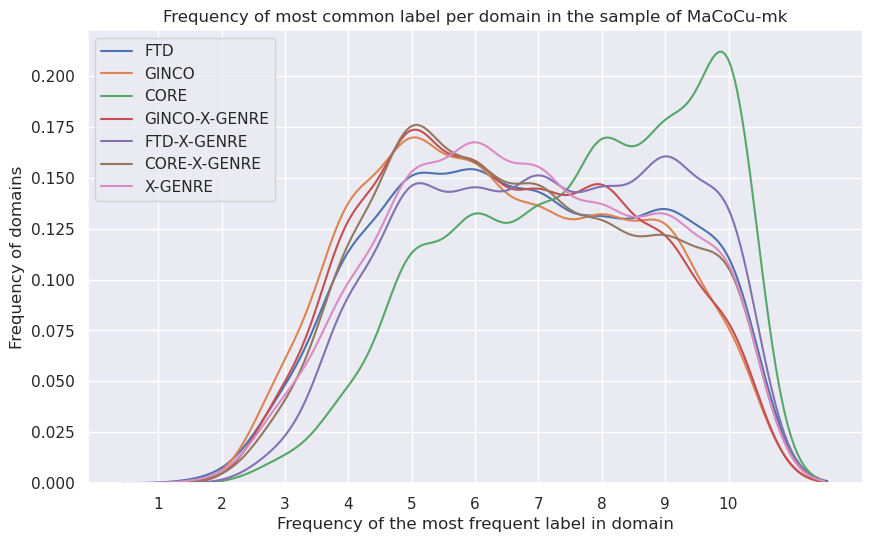

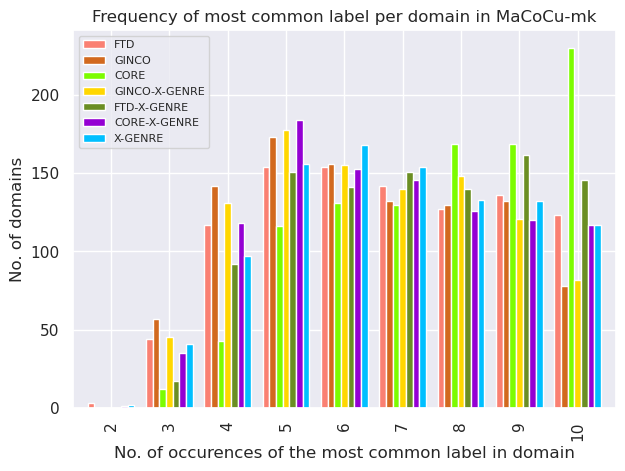

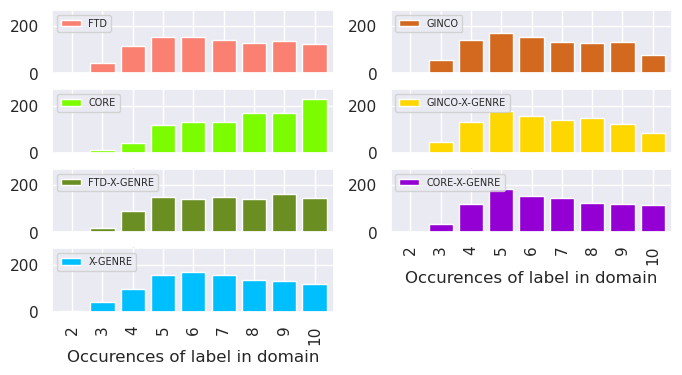

In [8]:
utils.create_graphs(genre_distribution, classifiers, "MaCoCu-mk")

### Most frequent labels per domain
We will look into how many times each specific category was most frequent on a domain. For this, I will use the domain-level corpus (genre_distribution dataframe). I will group the texts into domains and calculate for each label in each schema in how many domains it is the most frequent.

In [17]:
utils.label_distribution_per_domain(genre_distribution, classifiers)

| label_distribution_FTD       | label_distribution_GINCO             | label_distribution_CORE                         | label_distribution_GINCO-X-GENRE   | label_distribution_FTD-X-GENRE    | label_distribution_CORE-X-GENRE   | label_distribution_X-GENRE        |
|:-----------------------------|:-------------------------------------|:------------------------------------------------|:-----------------------------------|:----------------------------------|:----------------------------------|:----------------------------------|
| ('A12 (promotion)', 0.49)    | ('News/Reporting', 0.41)             | ('Informational Description/Explanation', 0.64) | ('News', 0.38)                     | ('Promotion', 0.48)               | ('Information/Explanation', 0.42) | ('News', 0.42)                    |
| ('A8 (news)', 0.22)          | ('Promotion', 0.26)                  | ('Narrative', 0.23)                             | ('Promotion', 0.32)                | ('News', 0.29)                    | ('Ne

### Calculating scores assuming domains are uni-genre
Calculating F1, precision, recall assuming that domains are uni-genre. To calculate this, I will take the predicted labels as y_pred and the most_frequent_label (most frequent label in domain) labels as y_true.

For this, I will use the extended corpus (which is instance-level, but contains the information on domains).

Classifier: FTD
Macro F1: 0.47, Micro F1: 0.68, Accuracy: 0.68
Krippendorfs Alpha: 0.55
                    precision    recall  f1-score   support

      A17 (review)       0.38      0.56      0.45       260
   A12 (promotion)       0.86      0.74      0.80      4930
A1 (argumentative)       0.55      0.64      0.59      1160
         A8 (news)       0.72      0.63      0.67      2240
  A7 (instruction)       0.37      0.59      0.45       280
 A16 (information)       0.46      0.60      0.52       930
    A14 (academic)       0.24      0.47      0.32        30
        A9 (legal)       0.25      0.53      0.34       100
    A11 (personal)       0.18      0.42      0.26        50
      A4 (fiction)       0.21      0.50      0.30        20

          accuracy                           0.68     10000
         macro avg       0.42      0.57      0.47     10000
      weighted avg       0.72      0.68      0.69     10000



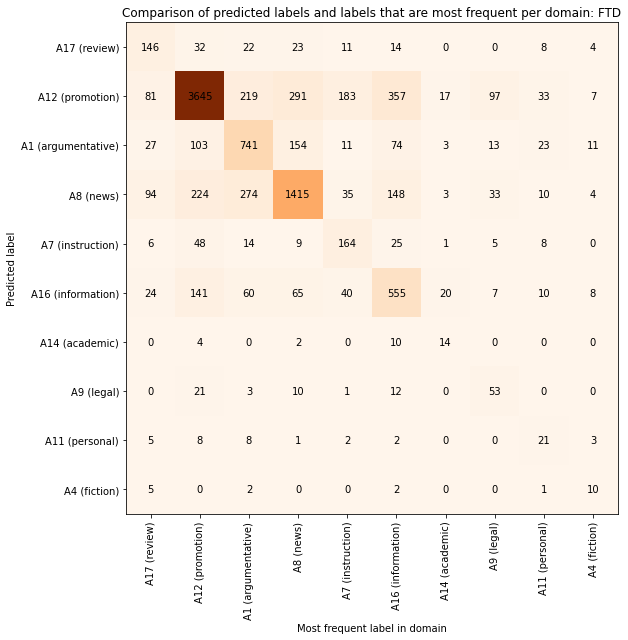

Classifier: GINCO
Macro F1: 0.51, Micro F1: 0.65, Accuracy: 0.65
Krippendorfs Alpha: 0.54
                            precision    recall  f1-score   support

List of Summaries/Excerpts       0.25      0.50      0.33       420
                 Promotion       0.78      0.72      0.75      2640
   Information/Explanation       0.55      0.60      0.58      1640
                     Other       0.11      0.41      0.18        90
               Instruction       0.40      0.60      0.48       330
            News/Reporting       0.85      0.66      0.74      4080
     Opinion/Argumentation       0.47      0.58      0.52       660
          Legal/Regulation       0.29      0.70      0.41        30
                     Forum       0.63      0.62      0.62       110

                  accuracy                           0.65     10000
                 macro avg       0.48      0.60      0.51     10000
              weighted avg       0.71      0.65      0.67     10000



<Figure size 432x288 with 0 Axes>

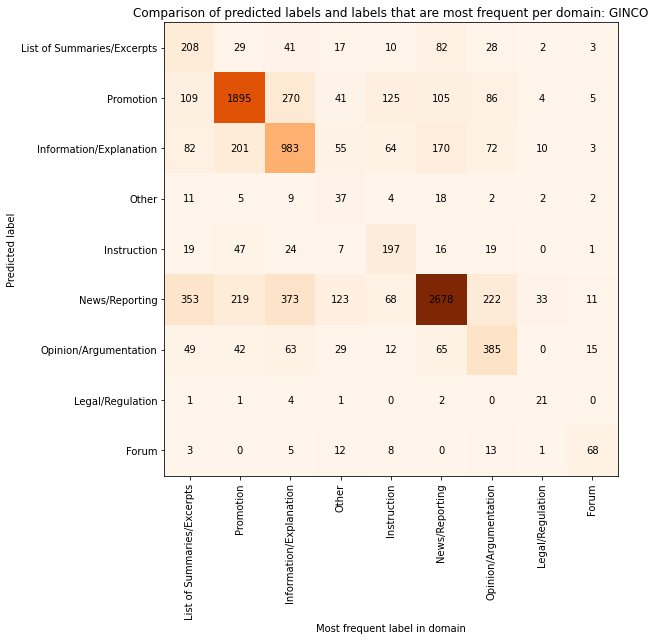

Classifier: CORE
Macro F1: 0.51, Micro F1: 0.77, Accuracy: 0.77
Krippendorfs Alpha: 0.59


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       precision    recall  f1-score   support

                              Opinion       0.42      0.56      0.48       330
Informational Description/Explanation       0.88      0.80      0.84      6370
                            Narrative       0.73      0.75      0.74      2330
             Informational Persuasion       0.52      0.62      0.57       620
                 How-To/Instructional       0.40      0.66      0.50       250
                               Spoken       0.00      0.00      0.00         0
                              Lyrical       0.33      0.43      0.37        30
               Interactive Discussion       0.49      0.64      0.56        70

                             accuracy                           0.77     10000
                            macro avg       0.47      0.56      0.51     10000
                         weighted avg       0.79      0.77      0.78     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

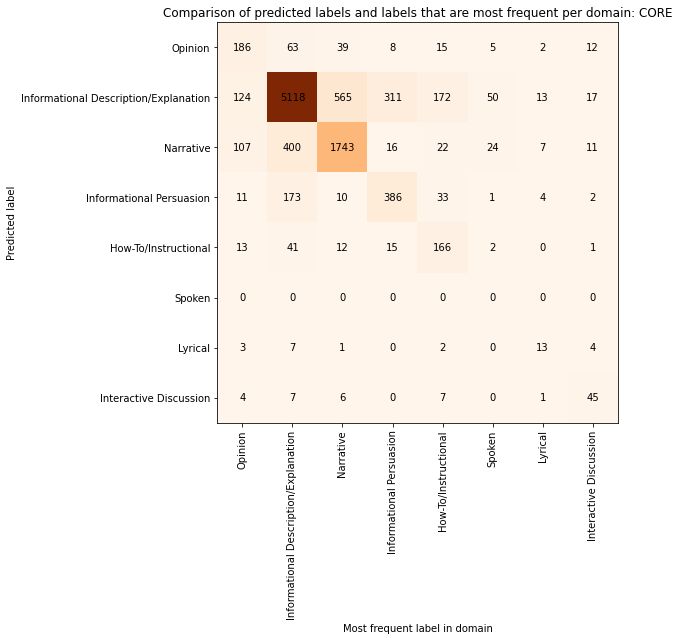

Classifier: GINCO-X-GENRE
Macro F1: 0.48, Micro F1: 0.66, Accuracy: 0.66
Krippendorfs Alpha: 0.54


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

  Opinion/Argumentation       0.46      0.56      0.51       520
              Promotion       0.77      0.69      0.73      3240
                   News       0.84      0.69      0.76      3750
                  Other       0.18      0.41      0.25       330
Information/Explanation       0.54      0.60      0.57      1670
            Instruction       0.40      0.64      0.49       360
                  Legal       0.22      0.83      0.35        30
          Prose/Lyrical       0.00      0.00      0.00         0
                  Forum       0.64      0.63      0.64       100

               accuracy                           0.66     10000
              macro avg       0.45      0.56      0.48     10000
           weighted avg       0.71      0.66      0.67     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

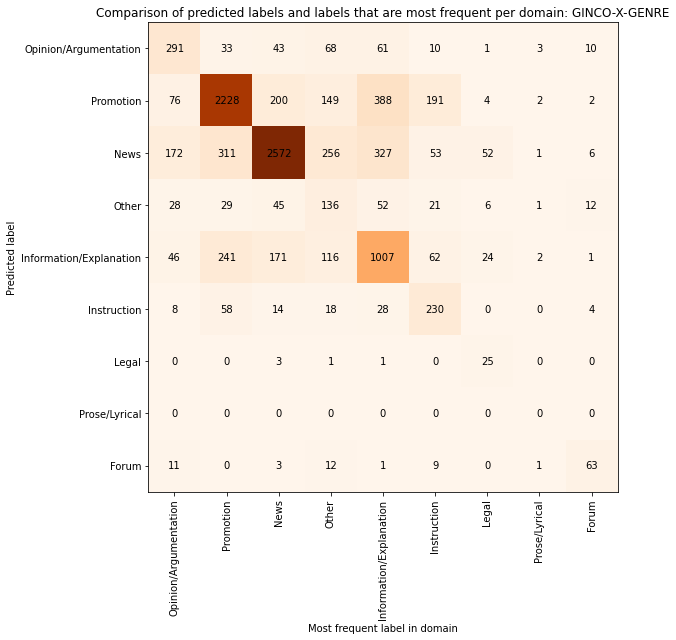

Classifier: FTD-X-GENRE
Macro F1: 0.52, Micro F1: 0.71, Accuracy: 0.71
Krippendorfs Alpha: 0.57
                         precision    recall  f1-score   support

              Promotion       0.82      0.75      0.78      4790
                   News       0.79      0.71      0.75      2940
Information/Explanation       0.54      0.66      0.59      1580
            Instruction       0.43      0.59      0.50       350
                  Legal       0.29      0.54      0.38       170
  Opinion/Argumentation       0.50      0.51      0.50       160
          Prose/Lyrical       0.07      0.60      0.12        10

               accuracy                           0.71     10000
              macro avg       0.49      0.62      0.52     10000
           weighted avg       0.74      0.71      0.72     10000



<Figure size 432x288 with 0 Axes>

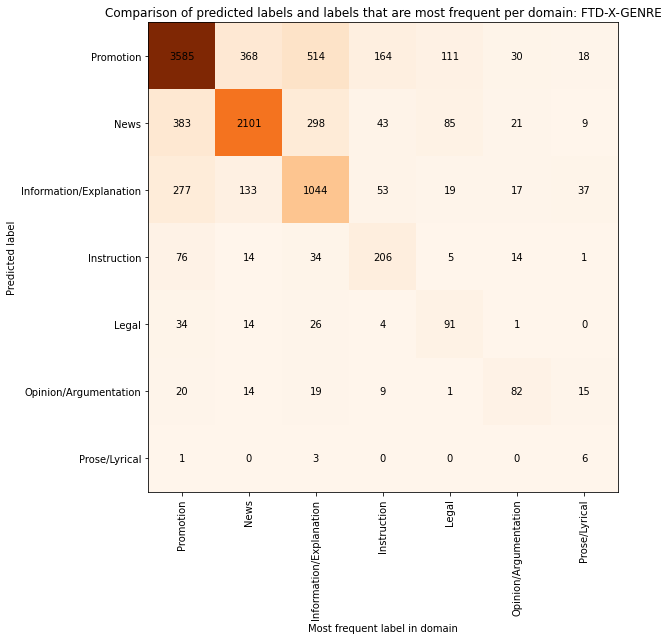

Classifier: CORE-X-GENRE
Macro F1: 0.51, Micro F1: 0.67, Accuracy: 0.67
Krippendorfs Alpha: 0.54
                         precision    recall  f1-score   support

  Opinion/Argumentation       0.37      0.52      0.43       890
                   News       0.80      0.73      0.77      3390
Information/Explanation       0.78      0.67      0.72      4220
            Instruction       0.52      0.63      0.57      1060
                  Forum       0.42      0.59      0.49       310
          Prose/Lyrical       0.29      0.51      0.37        90
                  Other       0.14      0.50      0.22        40

               accuracy                           0.67     10000
              macro avg       0.47      0.59      0.51     10000
           weighted avg       0.71      0.67      0.68     10000



<Figure size 432x288 with 0 Axes>

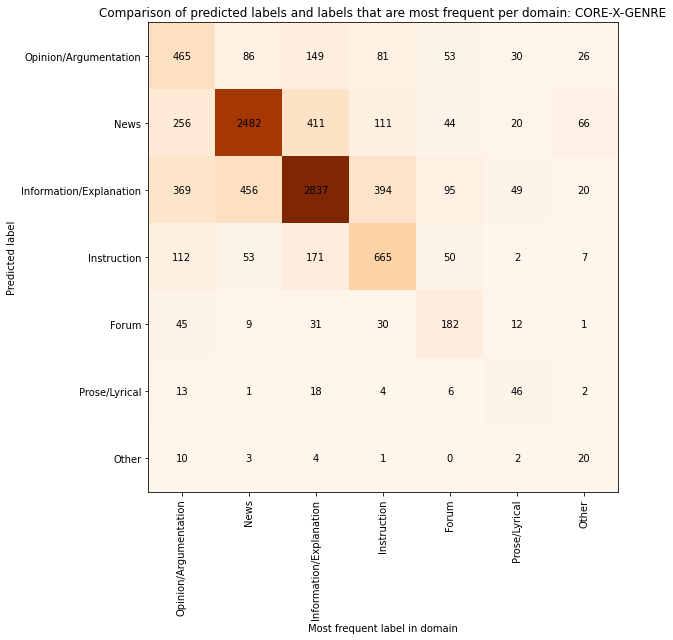

Classifier: X-GENRE
Macro F1: 0.5, Micro F1: 0.68, Accuracy: 0.68
Krippendorfs Alpha: 0.57
                         precision    recall  f1-score   support

  Opinion/Argumentation       0.41      0.60      0.49       520
              Promotion       0.78      0.72      0.75      2910
                   News       0.87      0.71      0.78      4170
Information/Explanation       0.52      0.61      0.56      1530
                  Other       0.13      0.41      0.20        80
            Instruction       0.48      0.59      0.53       530
          Prose/Lyrical       0.29      0.45      0.35        40
                  Forum       0.51      0.59      0.55       120
                  Legal       0.24      0.58      0.34       100

               accuracy                           0.68     10000
              macro avg       0.47      0.59      0.50     10000
           weighted avg       0.73      0.68      0.70     10000



<Figure size 432x288 with 0 Axes>

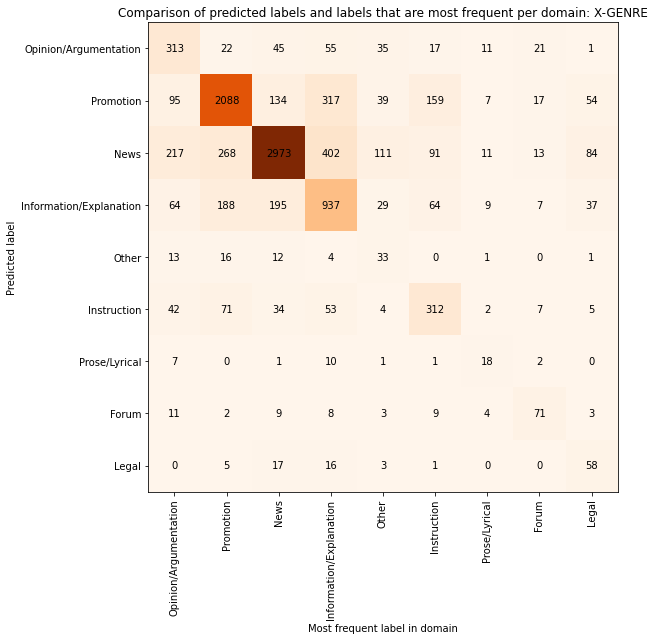

| Classifier    |   Accuracy |   Krippendorfs Alpha |   Macro F1 |   Micro F1 |   Macro precision |   Macro recall |
|:--------------|-----------:|---------------------:|-----------:|-----------:|------------------:|---------------:|
| FTD-X-GENRE   |       0.71 |                 0.57 |       0.52 |       0.71 |              0.49 |           0.62 |
| GINCO         |       0.65 |                 0.54 |       0.51 |       0.65 |              0.48 |           0.6  |
| CORE          |       0.77 |                 0.59 |       0.51 |       0.77 |              0.47 |           0.56 |
| CORE-X-GENRE  |       0.67 |                 0.54 |       0.51 |       0.67 |              0.47 |           0.59 |
| X-GENRE       |       0.68 |                 0.57 |       0.5  |       0.68 |              0.47 |           0.59 |
| GINCO-X-GENRE |       0.66 |                 0.54 |       0.48 |       0.66 |              0.45 |           0.56 |
| FTD           |       0.68 |                 0.55 |       0.47

<Figure size 432x288 with 0 Axes>

In [3]:
results_scores_based_on_domain = utils.scores_based_on_domains(extended_corpus, classifiers)

### Comparison based on label agreement inside domain

In [2]:
utils.calculate_hits(extended_corpus, genre_distribution, classifiers)

| Classifier    |   Hits |   Hits percentage |
|:--------------|-------:|------------------:|
| CORE          |  29151 |              0.65 |
| CORE-X-GENRE  |  23374 |              0.52 |
| FTD           |  23655 |              0.53 |
| FTD-X-GENRE   |  25862 |              0.57 |
| GINCO         |  21744 |              0.48 |
| GINCO-X-GENRE |  22255 |              0.49 |
| X-GENRE       |  23678 |              0.53 |


## Comparison of X-GENRE predictions based on the majority prediction
Focus only on X-genre and assume the domain label to be the one that has been chosen most by ALL classifiers, calculate F1, (microF1, macroF1). For this, we will use the extended corpus.

Number of ties when defining the majority label:
|     |   X-GENRE-majority-label-tie |
|:----|-----------------------------:|
| no  |                       0.8674 |
| yes |                       0.1326 |
Majority label distribution:
|                         |   X-GENRE-majority-label |
|:------------------------|-------------------------:|
| Information/Explanation |                   0.2663 |
| Promotion               |                   0.2089 |
| News                    |                   0.1755 |
| Opinion/Argumentation   |                   0.1562 |
| Forum                   |                   0.0641 |
| Instruction             |                   0.0586 |
| Other                   |                   0.0357 |
| Legal                   |                   0.0214 |
| Prose/Lyrical           |                   0.0133 |
Classifier: GINCO-X-GENRE
Macro F1: 0.73, Micro F1: 0.8, Accuracy: 0.8
                         precision    recall  f1-score   support

                   News 

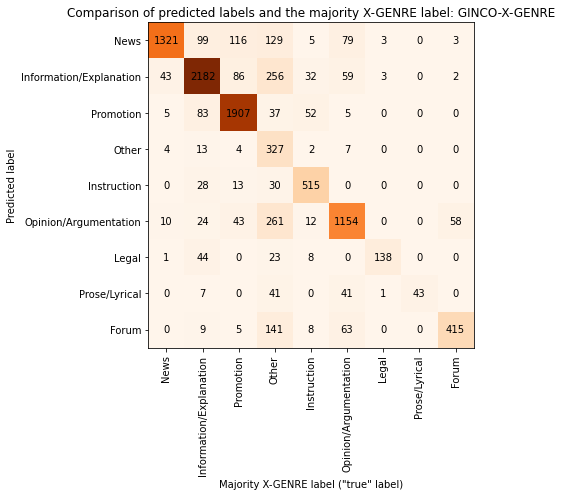

Classifier: FTD-X-GENRE
Macro F1: 0.68, Micro F1: 0.7, Accuracy: 0.67
                         precision    recall  f1-score   support

              Promotion       0.57      1.00      0.73      2089
Information/Explanation       0.73      0.75      0.74      2663
                  Legal       0.60      0.99      0.75       214
            Instruction       0.84      0.57      0.68       586
                   News       0.80      0.75      0.77      1755
  Opinion/Argumentation       0.63      0.42      0.50      1562
          Prose/Lyrical       0.52      0.71      0.61       133

              micro avg       0.67      0.74      0.70      9002
              macro avg       0.67      0.74      0.68      9002
           weighted avg       0.69      0.74      0.69      9002



<Figure size 432x288 with 0 Axes>

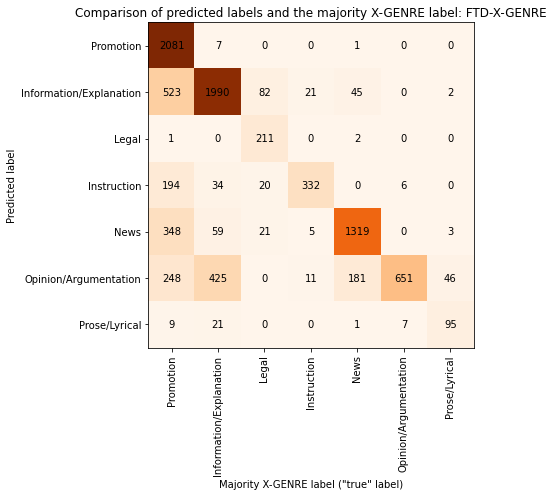

Classifier: CORE-X-GENRE
Macro F1: 0.6, Micro F1: 0.67, Accuracy: 0.6
                         precision    recall  f1-score   support

Information/Explanation       0.64      0.90      0.75      2663
            Instruction       0.53      0.78      0.63       586
  Opinion/Argumentation       0.51      0.53      0.52      1562
                   News       0.79      0.81      0.80      1755
                  Forum       0.44      0.96      0.60       641
                  Other       0.50      0.29      0.36       357
          Prose/Lyrical       0.35      0.96      0.51       133

              micro avg       0.60      0.77      0.67      7697
              macro avg       0.54      0.75      0.60      7697
           weighted avg       0.61      0.77      0.67      7697



<Figure size 432x288 with 0 Axes>

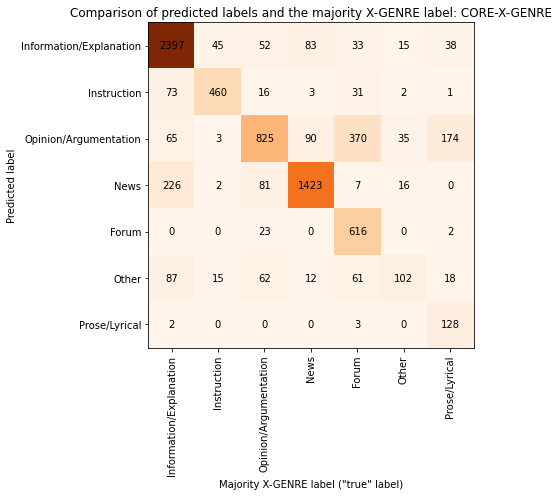

Classifier: X-GENRE
Macro F1: 0.83, Micro F1: 0.84, Accuracy: 0.84
                         precision    recall  f1-score   support

                   News       0.80      0.94      0.86      1755
                  Legal       0.76      0.87      0.81       214
Information/Explanation       0.95      0.77      0.85      2663
              Promotion       0.96      0.75      0.85      2089
                  Other       0.56      0.78      0.65       357
            Instruction       0.84      0.88      0.86       586
  Opinion/Argumentation       0.73      0.94      0.82      1562
                  Forum       0.86      0.90      0.88       641
          Prose/Lyrical       0.95      0.76      0.85       133

               accuracy                           0.84     10000
              macro avg       0.82      0.84      0.83     10000
           weighted avg       0.86      0.84      0.84     10000



<Figure size 432x288 with 0 Axes>

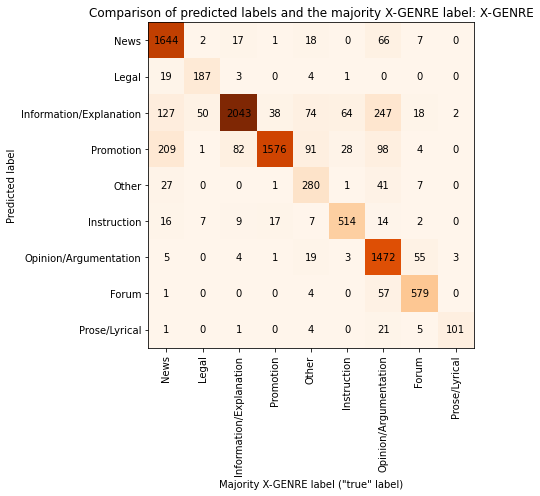

| Classifier    |   Accuracy |   Macro F1 |   Micro F1 |   Macro precision |   Macro recall |
|:--------------|-----------:|-----------:|-----------:|------------------:|---------------:|
| X-GENRE       |       0.84 |       0.83 |       0.84 |              0.82 |           0.84 |
| GINCO-X-GENRE |       0.8  |       0.73 |       0.8  |              0.82 |           0.74 |
| FTD-X-GENRE   |       0.67 |       0.68 |       0.7  |              0.67 |           0.74 |
| CORE-X-GENRE  |       0.6  |       0.6  |       0.67 |              0.54 |           0.75 |


<Figure size 432x288 with 0 Axes>

In [4]:
x_genre_majority_results = utils.scores_based_on_xgenre_majority(extended_corpus, "MaCoCu-is")

## Agreement between X-GENRE classifiers
For X-genre classifiers, calculate agreement between them via F1, macroF1, microF1 (one classifier y_pred, another y_true - confusion matrix).

Comparison of classifiers: GINCO-X-GENRE as y_true, FTD-X-GENRE as y_pred
Macro F1: 0.56, Micro F1: 0.63
                         precision    recall  f1-score   support

              Promotion       0.57      0.95      0.71      2174
Information/Explanation       0.60      0.66      0.63      2489
                  Legal       0.39      0.95      0.56       145
            Instruction       0.77      0.48      0.59       634
                   News       0.64      0.76      0.70      1384
  Opinion/Argumentation       0.53      0.39      0.45      1408
          Prose/Lyrical       0.17      0.72      0.28        43

              micro avg       0.58      0.70      0.63      8277
              macro avg       0.52      0.70      0.56      8277
           weighted avg       0.59      0.70      0.63      8277



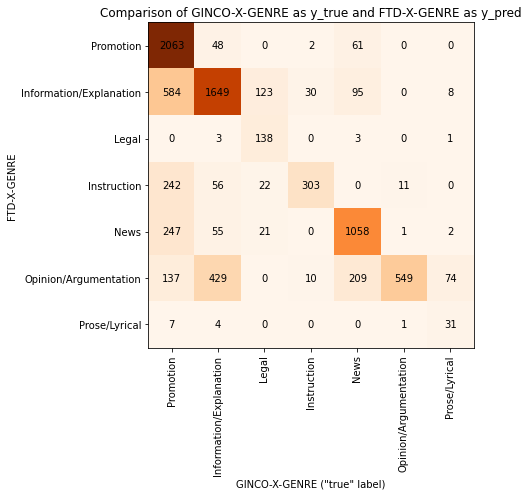

Comparison of classifiers: GINCO-X-GENRE as y_true, CORE-X-GENRE as y_pred
Macro F1: 0.43, Micro F1: 0.52
                         precision    recall  f1-score   support

Information/Explanation       0.54      0.82      0.65      2489
            Instruction       0.49      0.67      0.56       634
  Opinion/Argumentation       0.33      0.38      0.35      1408
                   News       0.60      0.77      0.67      1384
                  Forum       0.30      0.88      0.45       478
                  Other       0.42      0.07      0.12      1245
          Prose/Lyrical       0.11      0.98      0.20        43

              micro avg       0.46      0.60      0.52      7681
              macro avg       0.40      0.65      0.43      7681
           weighted avg       0.47      0.60      0.49      7681



<Figure size 432x288 with 0 Axes>

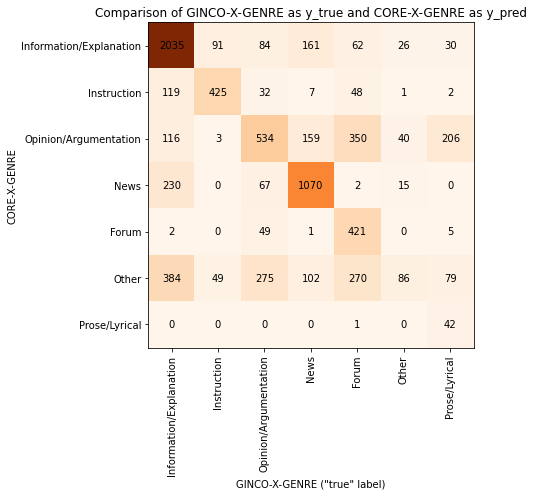

Comparison of classifiers: GINCO-X-GENRE as y_true, X-GENRE as y_pred
Macro F1: 0.65, Micro F1: 0.7
                         precision    recall  f1-score   support

                   News       0.63      0.93      0.75      1384
                  Legal       0.48      0.81      0.60       145
Information/Explanation       0.82      0.72      0.77      2489
              Promotion       0.89      0.67      0.76      2174
                  Other       0.55      0.22      0.32      1245
            Instruction       0.75      0.72      0.74       634
  Opinion/Argumentation       0.58      0.83      0.68      1408
                  Forum       0.55      0.78      0.65       478
          Prose/Lyrical       0.40      0.98      0.56        43

               accuracy                           0.70     10000
              macro avg       0.63      0.74      0.65     10000
           weighted avg       0.72      0.70      0.68     10000



<Figure size 432x288 with 0 Axes>

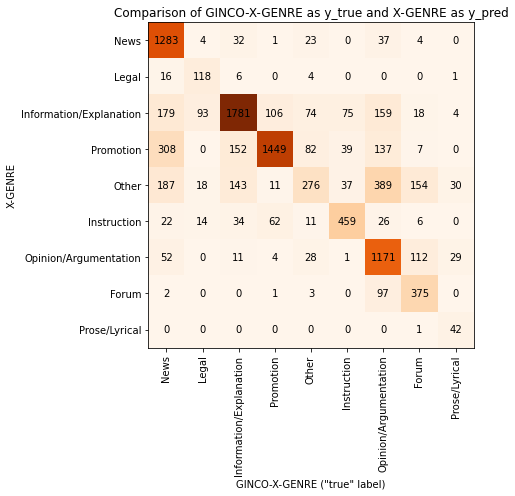

Comparison of classifiers: FTD-X-GENRE as y_true, GINCO-X-GENRE as y_pred
Macro F1: 0.56, Micro F1: 0.63
                         precision    recall  f1-score   support

              Promotion       0.95      0.57      0.71      3636
Information/Explanation       0.66      0.60      0.63      2741
                  Legal       0.95      0.39      0.56       351
            Instruction       0.48      0.77      0.59       396
                   News       0.76      0.64      0.70      1654
  Opinion/Argumentation       0.39      0.53      0.45      1041
          Prose/Lyrical       0.72      0.17      0.28       181

              micro avg       0.70      0.58      0.63     10000
              macro avg       0.70      0.52      0.56     10000
           weighted avg       0.76      0.58      0.64     10000



<Figure size 432x288 with 0 Axes>

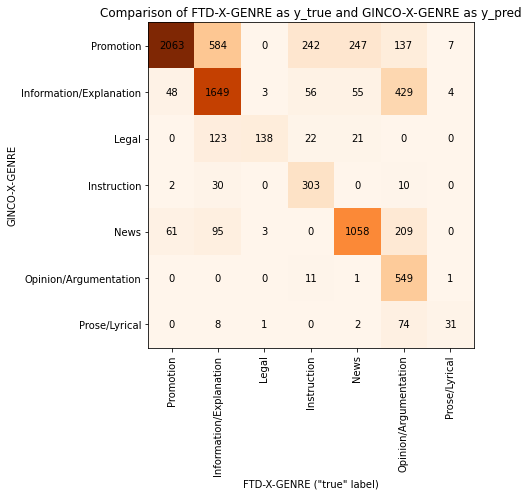

Comparison of classifiers: FTD-X-GENRE as y_true, CORE-X-GENRE as y_pred
Macro F1: 0.32, Micro F1: 0.4


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.

                         precision    recall  f1-score   support

              Promotion       0.00      0.00      0.00      3636
Information/Explanation       0.50      0.69      0.58      2741
                  Legal       0.00      0.00      0.00       351
            Instruction       0.31      0.68      0.42       396
                   News       0.65      0.70      0.68      1654
  Opinion/Argumentation       0.16      0.24      0.19      1041
          Prose/Lyrical       0.29      0.59      0.39       181

              micro avg       0.44      0.37      0.40     10000
              macro avg       0.27      0.41      0.32     10000
           weighted avg       0.28      0.37      0.32     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

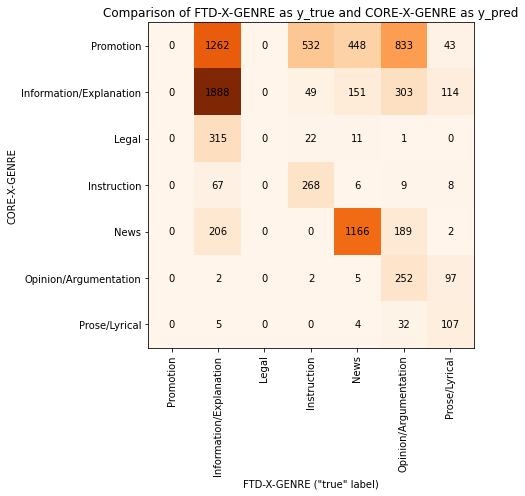

Comparison of classifiers: FTD-X-GENRE as y_true, X-GENRE as y_pred
Macro F1: 0.59, Micro F1: 0.6
                         precision    recall  f1-score   support

              Promotion       0.99      0.44      0.61      3636
Information/Explanation       0.71      0.56      0.63      2741
                  Legal       0.87      0.62      0.72       351
            Instruction       0.52      0.80      0.63       396
                   News       0.60      0.74      0.66      1654
  Opinion/Argumentation       0.31      0.61      0.41      1041
          Prose/Lyrical       0.66      0.39      0.49       181

              micro avg       0.64      0.56      0.60     10000
              macro avg       0.67      0.59      0.59     10000
           weighted avg       0.75      0.56      0.61     10000



<Figure size 432x288 with 0 Axes>

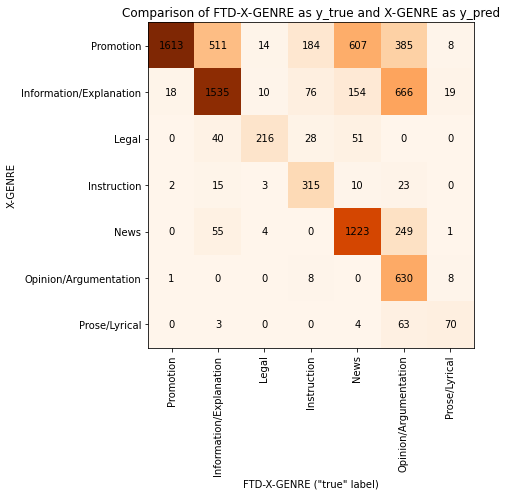

Comparison of classifiers: CORE-X-GENRE as y_true, GINCO-X-GENRE as y_pred
Macro F1: 0.33, Micro F1: 0.46


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

                   News       0.77      0.60      0.67      1791
Information/Explanation       0.82      0.54      0.65      3745
              Promotion       0.00      0.00      0.00         0
                  Other       0.07      0.42      0.12       203
            Instruction       0.67      0.49      0.56       873
  Opinion/Argumentation       0.38      0.33      0.35      1619
                  Legal       0.00      0.00      0.00         0
          Prose/Lyrical       0.98      0.11      0.20       371
                  Forum       0.88      0.30      0.45      1398

               accuracy                           0.46     10000
              macro avg       0.51      0.31      0.33     10000
           weighted avg       0.73      0.46      0.54     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

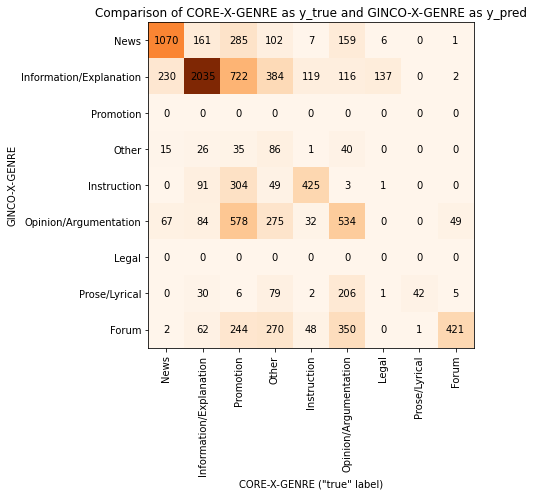

Comparison of classifiers: CORE-X-GENRE as y_true, FTD-X-GENRE as y_pred
Macro F1: 0.32, Micro F1: 0.4


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

              Promotion       0.00      0.00      0.00         0
Information/Explanation       0.69      0.50      0.58      3745
                  Legal       0.00      0.00      0.00         0
            Instruction       0.68      0.31      0.42       873
                   News       0.70      0.65      0.68      1791
  Opinion/Argumentation       0.24      0.16      0.19      1619
          Prose/Lyrical       0.59      0.29      0.39       371

              micro avg       0.37      0.44      0.40      8399
              macro avg       0.41      0.27      0.32      8399
           weighted avg       0.60      0.44      0.50      8399



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

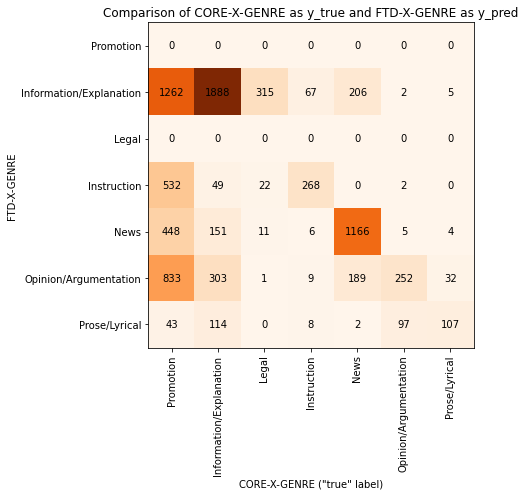

Comparison of classifiers: CORE-X-GENRE as y_true, X-GENRE as y_pred
Macro F1: 0.4, Micro F1: 0.53


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

                   News       0.69      0.79      0.73      1791
                  Legal       0.00      0.00      0.00         0
Information/Explanation       0.89      0.51      0.65      3745
              Promotion       0.00      0.00      0.00         0
                  Other       0.15      0.38      0.22       203
            Instruction       0.70      0.49      0.57       873
  Opinion/Argumentation       0.41      0.51      0.45      1619
                  Forum       0.88      0.42      0.57      1398
          Prose/Lyrical       0.95      0.27      0.42       371

               accuracy                           0.53     10000
              macro avg       0.52      0.37      0.40     10000
           weighted avg       0.74      0.53      0.60     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

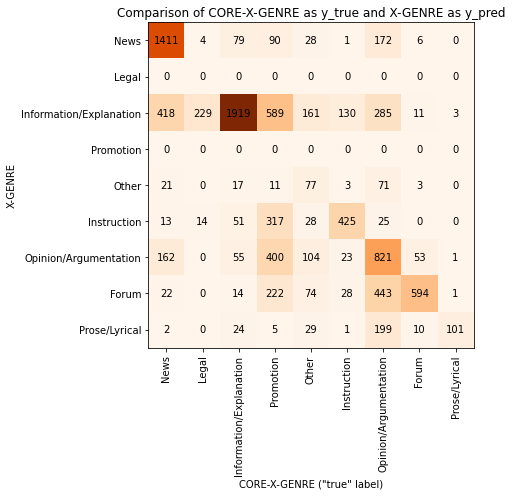

Comparison of classifiers: X-GENRE as y_true, GINCO-X-GENRE as y_pred
Macro F1: 0.65, Micro F1: 0.7
                         precision    recall  f1-score   support

                   News       0.93      0.63      0.75      2049
Information/Explanation       0.72      0.82      0.77      2159
              Promotion       0.67      0.89      0.76      1634
                  Other       0.22      0.55      0.32       501
            Instruction       0.72      0.75      0.74       611
  Opinion/Argumentation       0.83      0.58      0.68      2016
                  Legal       0.81      0.48      0.60       247
          Prose/Lyrical       0.98      0.40      0.56       106
                  Forum       0.78      0.55      0.65       677

               accuracy                           0.70     10000
              macro avg       0.74      0.63      0.65     10000
           weighted avg       0.76      0.70      0.71     10000



<Figure size 432x288 with 0 Axes>

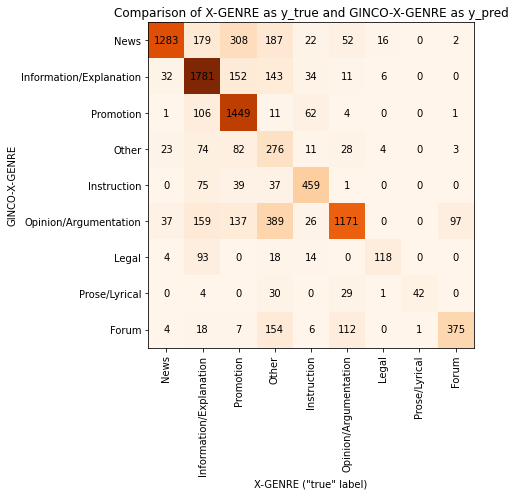

Comparison of classifiers: X-GENRE as y_true, FTD-X-GENRE as y_pred
Macro F1: 0.59, Micro F1: 0.6
                         precision    recall  f1-score   support

              Promotion       0.44      0.99      0.61      1634
Information/Explanation       0.56      0.71      0.63      2159
                  Legal       0.62      0.87      0.72       247
            Instruction       0.80      0.52      0.63       611
                   News       0.74      0.60      0.66      2049
  Opinion/Argumentation       0.61      0.31      0.41      2016
          Prose/Lyrical       0.39      0.66      0.49       106

              micro avg       0.56      0.64      0.60      8822
              macro avg       0.59      0.67      0.59      8822
           weighted avg       0.61      0.64      0.58      8822



<Figure size 432x288 with 0 Axes>

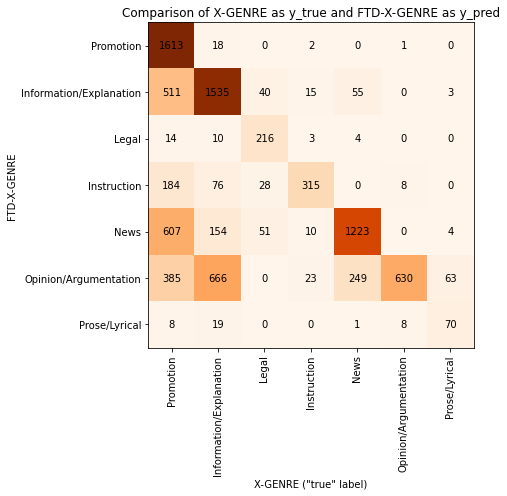

Comparison of classifiers: X-GENRE as y_true, CORE-X-GENRE as y_pred
Macro F1: 0.52, Micro F1: 0.59
                         precision    recall  f1-score   support

Information/Explanation       0.51      0.89      0.65      2159
            Instruction       0.49      0.70      0.57       611
  Opinion/Argumentation       0.51      0.41      0.45      2016
                   News       0.79      0.69      0.73      2049
                  Forum       0.42      0.88      0.57       677
                  Other       0.38      0.15      0.22       501
          Prose/Lyrical       0.27      0.95      0.42       106

              micro avg       0.53      0.66      0.59      8119
              macro avg       0.48      0.67      0.52      8119
           weighted avg       0.56      0.66      0.58      8119



<Figure size 432x288 with 0 Axes>

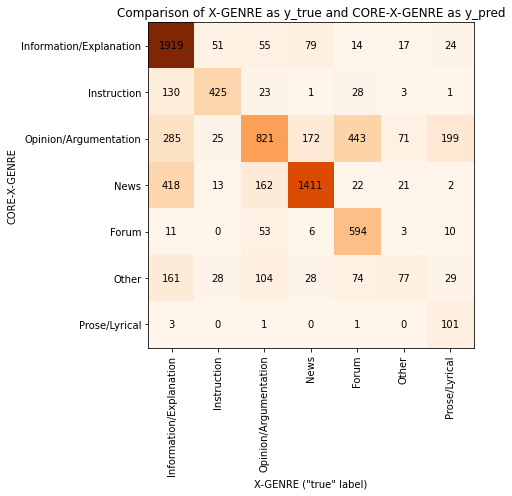

| Classifier as y_true   | Classifier as y_pred   |   Macro F1 |   Micro F1 |   Macro precision |   Macro recall |
|:-----------------------|:-----------------------|-----------:|-----------:|------------------:|---------------:|
| GINCO-X-GENRE          | X-GENRE                |       0.65 |       0.7  |              0.63 |           0.74 |
| X-GENRE                | GINCO-X-GENRE          |       0.65 |       0.7  |              0.74 |           0.63 |
| FTD-X-GENRE            | X-GENRE                |       0.59 |       0.6  |              0.67 |           0.59 |
| X-GENRE                | FTD-X-GENRE            |       0.59 |       0.6  |              0.59 |           0.67 |
| GINCO-X-GENRE          | FTD-X-GENRE            |       0.56 |       0.63 |              0.52 |           0.7  |
| FTD-X-GENRE            | GINCO-X-GENRE          |       0.56 |       0.63 |              0.7  |           0.52 |
| X-GENRE                | CORE-X-GENRE           |       0.52 |       0.59 |   

<Figure size 432x288 with 0 Axes>

In [4]:
utils.x_genre_classifier_agreement(extended_corpus)

# Analysis of which labels often occur together

I had another idea that we could analyse which labels occur together using the apriori algorithm which is used in association rule learning.

Main concepts:

- Support: It measures the number of times a particular item or combination of items occur in a dataset out of the number of all instances.
`Support(pair) = frequency_of_pair/no_of_instances`

- Confidence: It measures how likely the pair will occur given they the left value has been predicted - number of times both have been predicted together divided by a number of time the left value has been predicted (-> if the left value occurs very often, the confidence will be smaller)
`Confidence(pair (based of occurrence of left value)) = frequency_of_pair/frequency of left value`

- Lift: A lift is a metric that determines the strength of association between the best rules. It is obtained by taking confidence (based on the frequency of the left value and right value) dand diving it with support (for right value). 
`Lift(pair (based on occurrence of left value)) = Confidence(based on occurrence of left value)/Support(right value)}`

This means that if left value is very frequent -> confidence is smaller, if the pair does not occur together very often, it won't reach the confidence limit. The frequency of right value does not impact the confidence, but it does impact the lift. For the same number of occurences of the pair, the lift is higher if one of them is infrequent than if both were frequent. The bigger support (frequency of the pair occuring together), the bigger is lift.

two most frequent values, always occurring together:
left = 7
right = 7

occur = 7/10
total = 10

confidence = 7/10 / 7/10 = 1

support = 7/10

lift = 1 / 0.7 = 1.42

-----------
two not so frequent values always occurring together:

left = 4
right = 4

occur = 4/10

confidence = 1

support = 0.4

lift = 1/0.4 = 2.5

In [4]:
utils.calculate_apriori(extended_corpus, classifiers)

/home/tajak/Genre-Datasets-Comparison/Genre-Datasets-Comparison/Comparison-on-MaCoCu-data/Comparison-on-MaCoCu-is/utils.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_small[i] = "{}: ".format(i) + corpus_small[i].astype(str)


Comparison: FTD with GINCO
| Left_Hand_Side          | Right_Hand_Side                |   Support |   Confidence |     Lift |
|:------------------------|:-------------------------------|----------:|-------------:|---------:|
| GINCO: Legal/Regulation | FTD: A9 (legal)                |    0.0106 |     0.929825 | 38.5819  |
| FTD: A7 (instruction)   | GINCO: Instruction             |    0.0306 |     0.69863  | 13.592   |
| FTD: A8 (news)          | GINCO: News/Reporting          |    0.0679 |     0.746154 |  4.82323 |
| FTD: A11 (personal)     | GINCO: Opinion/Argumentation   |    0.0566 |     0.702233 |  3.15469 |
| GINCO: Promotion        | FTD: A12 (promotion)           |    0.1383 |     0.951169 |  3.1145  |
| FTD: A16 (information)  | GINCO: Information/Explanation |    0.1517 |     0.748028 |  3.03091 |
| GINCO: Forum            | FTD: A1 (argumentative)        |    0.0355 |     0.5573   |  2.90866 |
| FTD: A1 (argumentative) | GINCO: Opinion/Argumentation   |    0.0958 |     0.5  